# Классификация тарелок (чистая/грязная)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('/kaggle/input/platesv2/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['platesv2']
After zip extraction:
['__MACOSX', '.virtual_documents', 'plates']


In [2]:
import shutil 
import time
import copy
from tqdm import tqdm

import cv2
import torch
import torch.nn as nn
import torchvision
import torchvision.models as M
import torchvision.transforms.v2 as TV2

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['.DS_Store', 'train', 'test']


In [4]:
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 5614.15it/s]


In [5]:
!ls train

cleaned  dirty


In [114]:
train_transformer = TV2.Compose([
    TV2.ToImage(),
    TV2.RandomResizedCrop(256, antialias=True),
    TV2.RandomHorizontalFlip(),
    TV2.ColorJitter(
        brightness=0.5, contrast=0.5,
        saturation=0.5, hue=0.3
    ),
    TV2.RandomSolarize(threshold=210.0),
    TV2.ToDtype(torch.float32, scale=True),
    TV2.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


val_transforer = TV2.Compose([
    TV2.ToImage(),
    TV2.Resize((256, 256), antialias=True),
    TV2.ToDtype(torch.float32, scale=True),
    TV2.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = ImageFolder(train_dir, train_transformer)
val_dataset = ImageFolder(val_dir, val_transforer)

BATCH_SIZE = 8

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=os.cpu_count()
)

val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=os.cpu_count()
)

In [115]:
len(train_dataloader), len(train_dataset)

(4, 32)

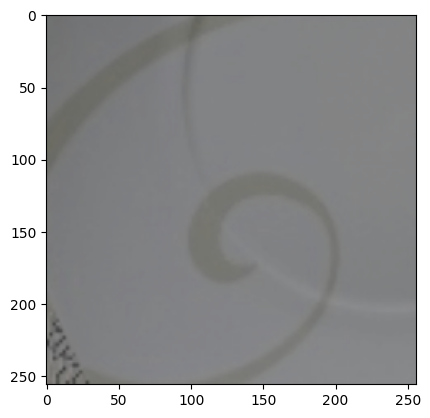

In [116]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

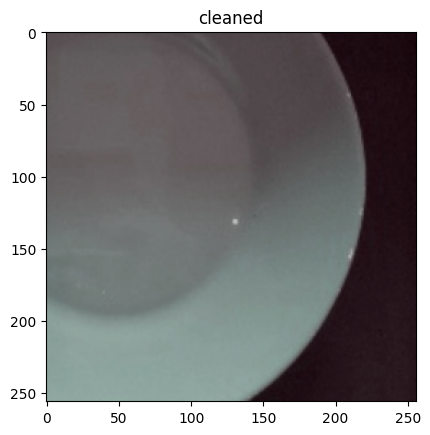

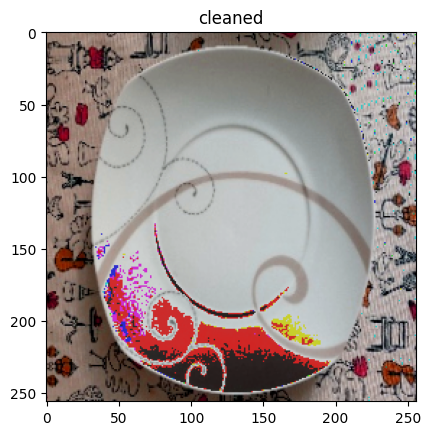

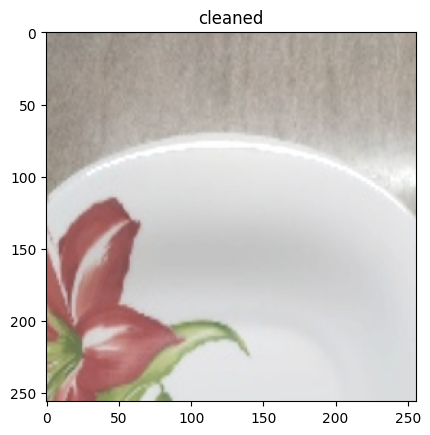

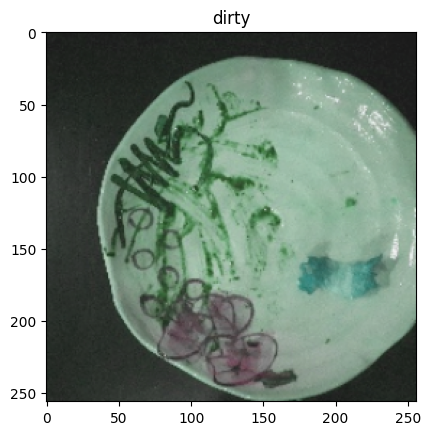

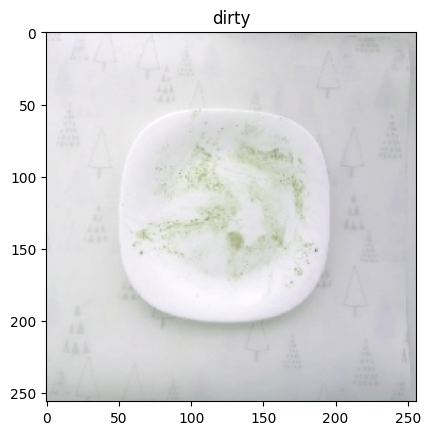

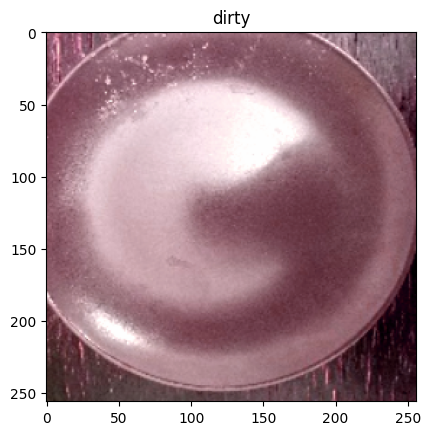

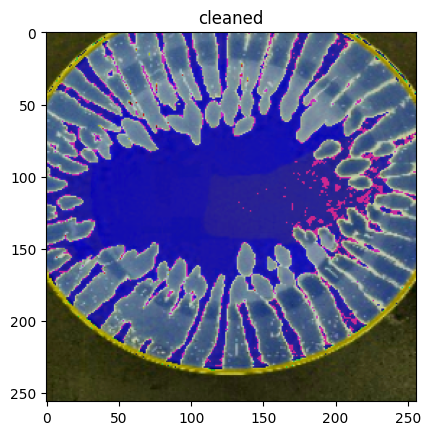

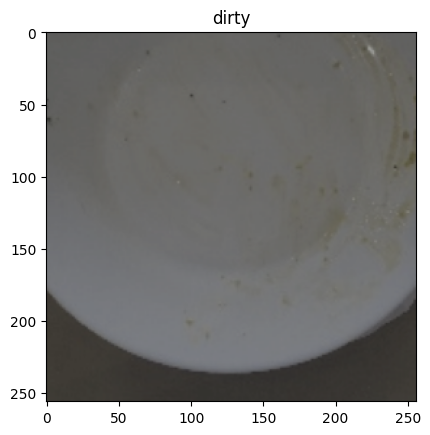

In [117]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [136]:
def train_model(model, loss, optimizer, scheduler=None, num_epochs=50, rep_freq=10):
    loss_train_history = []
    acc_train_history = []
    loss_val_history = []
    acc_val_history = []
    flag=1
    
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        if scheduler:
                            scheduler.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            # вывод отчета о динамике с указанной частотой
            if (not epoch % rep_freq):
                flag+=1
                if not flag % 2: 
                    print('Epoch {}/{}:'.format(epoch, num_epochs - 1))
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if(phase=='train'):
                loss_train_history.append(epoch_loss)
                acc_train_history.append(epoch_acc.item())
            else:
                loss_val_history.append(epoch_loss)
                acc_val_history.append(epoch_acc.item())

    return model, [loss_train_history, loss_val_history], [acc_train_history, acc_val_history]

In [137]:
model = M.resnet34(weights=M.ResNet34_Weights.IMAGENET1K_V1)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

    
print(model.fc)
model.fc = nn.Sequential(
    nn.Dropout(0.4), nn.Linear(model.fc.in_features, 64), nn.ReLU(),
    nn.BatchNorm1d(num_features=64), nn.Dropout(0.3), nn.Linear(64,2)
)
print(model.fc)

total_params = sum(p.numel() for p in model.parameters())
print("Total parameters: ", total_params)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)

# Decay LR by a factor of 0.1 every 7 epochs
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Linear(in_features=512, out_features=1000, bias=True)
Sequential(
  (0): Dropout(p=0.4, inplace=False)
  (1): Linear(in_features=512, out_features=64, bias=True)
  (2): ReLU()
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.3, inplace=False)
  (5): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  21317762
Device: cuda:0


In [138]:
for param in model.layer4.parameters():
    param.requires_grad = True

In [139]:
model, loss_history, acc_history = train_model(
    model, loss, optimizer,#  scheduler,
    num_epochs=100, rep_freq=25
)

Epoch 0/99:
train Loss: 0.7475 Acc: 0.5625
val Loss: 0.6445 Acc: 0.6250
Epoch 25/99:
train Loss: 0.2079 Acc: 0.9688
val Loss: 0.5360 Acc: 0.6250
Epoch 50/99:
train Loss: 0.1561 Acc: 0.9688
val Loss: 0.3763 Acc: 0.8750
Epoch 75/99:
train Loss: 0.0867 Acc: 0.9688
val Loss: 0.8776 Acc: 0.7500


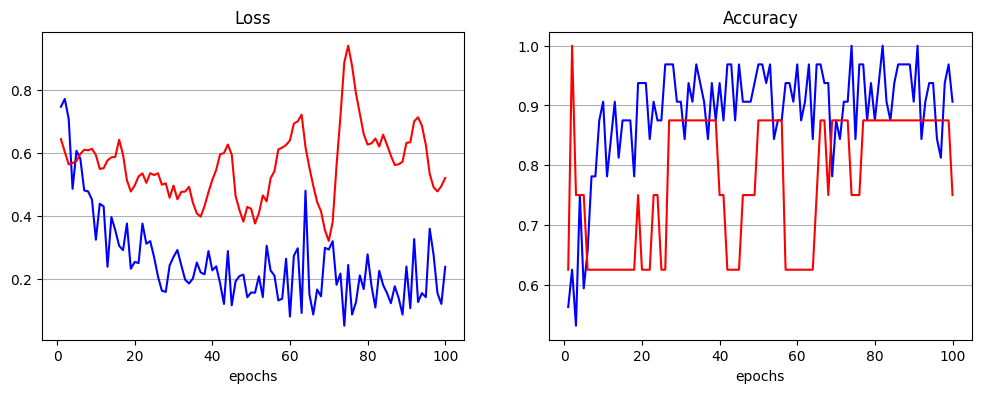

In [140]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(range(1, len(loss_history[0]) + 1), loss_history[0], color="b")
plt.plot(range(1, len(loss_history[1]) + 1), loss_history[1], color="r")
plt.xlabel("epochs")
plt.title("Loss")
plt.grid(axis='y')
plt.subplot(122)
plt.plot(range(1, len(acc_history[0]) + 1), acc_history[0], color="b")
plt.plot(range(1, len(acc_history[1]) + 1), acc_history[1], color="r")
plt.xlabel("epochs")
plt.title("Accuracy")
plt.grid(axis='y')

plt.show()

In [141]:
test_dir = 'test'
try:
    shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))
except FileExistsError:
    print("Папка уже существует")

Папка уже существует


In [142]:
class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforer)

test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=0
)

In [143]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToDtype(scale=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

In [144]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 27.80it/s]


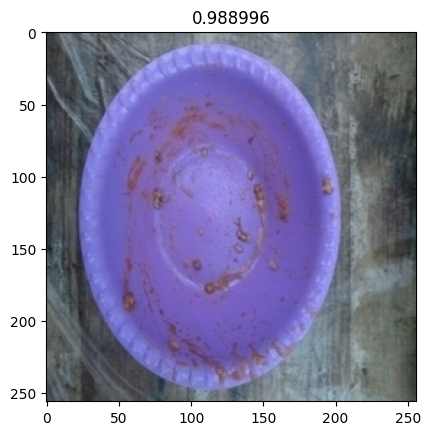

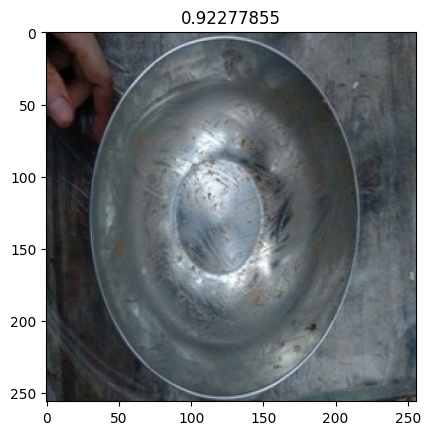

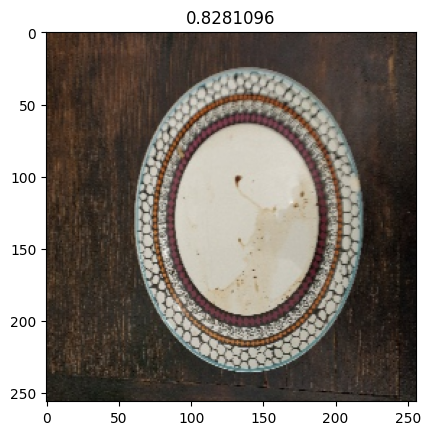

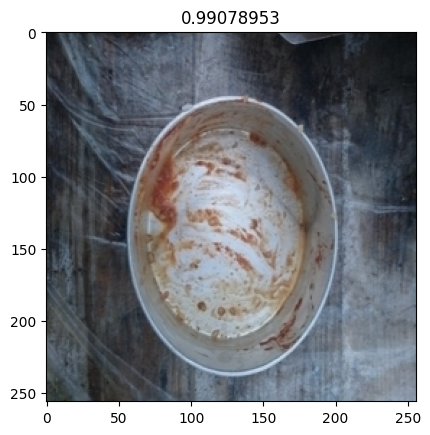

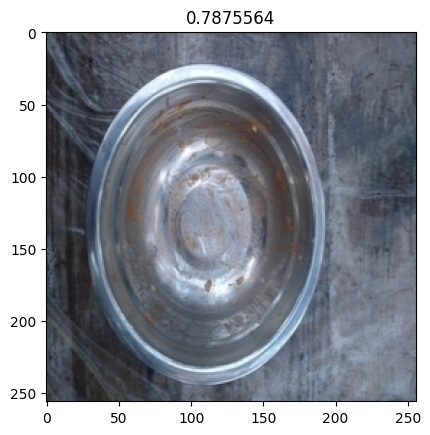

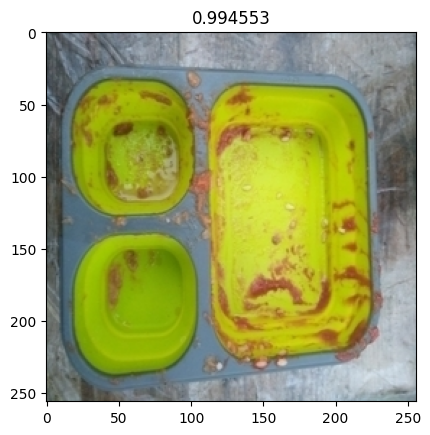

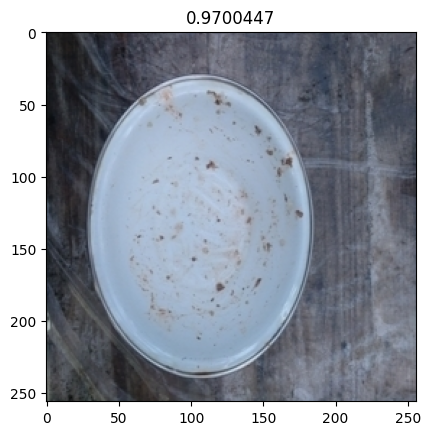

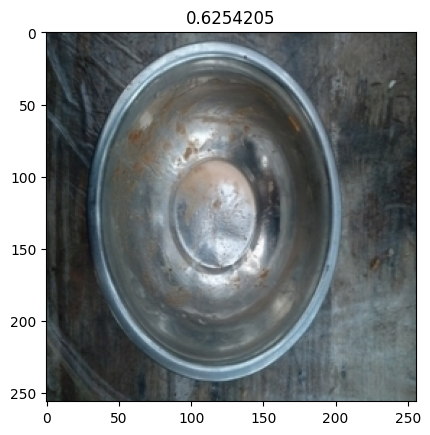

In [145]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [146]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [147]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id         
0000  dirty
0001  dirty
0002  dirty
0003  dirty
0004  dirty
0005  dirty

In [148]:
submission_df.to_csv('submission.csv')

In [20]:
!rm -rf train val test